# Modeling Stock Movement & Algorithmic Trading
Brian Bahmanyar

***

## Motivation

* Understanding the movement of markets and stocks is fundamentally a very difficult problem.
    * Human behavior is unpredictable
* The goal of this project is outpreform the Standard and Poor's 500 which historically yeilds an average return of about 10%.
    * To do this we exploite patterns in stock movement

## Exploring a Single Stock

In [1]:
import pandas as pd
import sys

sys.path.append('./src/')
from plots import *
from random_walk_forcast import *
from pairs_trade import *

In [2]:
%matplotlib inline

In [3]:
tech = pd.read_csv('data/tech_bundle.csv', index_col=0)
tech.index = pd.to_datetime(tech.index)

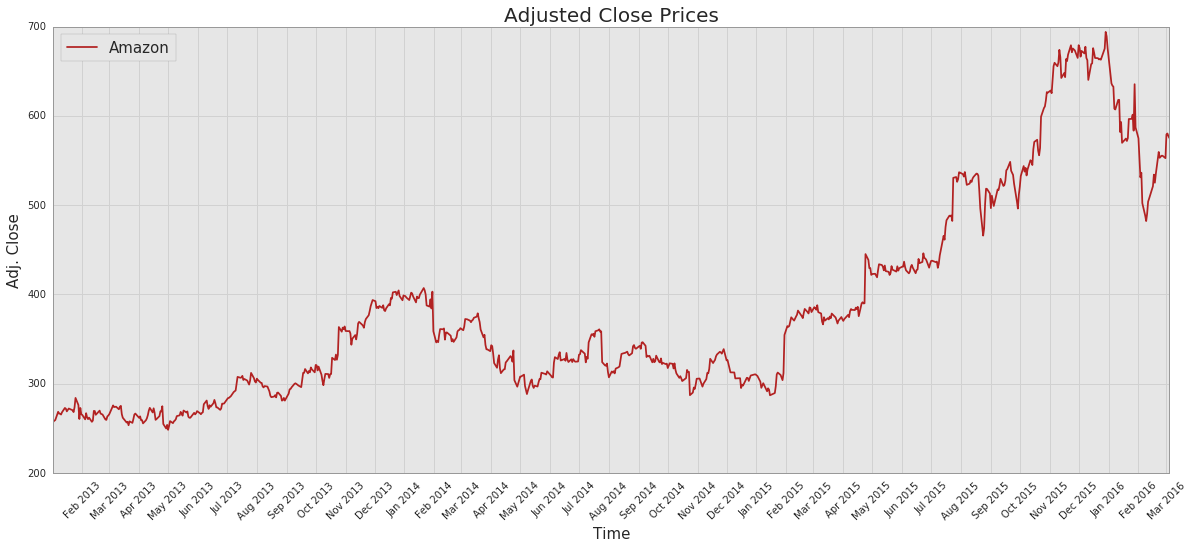

In [4]:
plot_stocks(tech.index, [tech['AMZN']], ['Amazon'], label_annually=False )

* We see an obvious general positive trend, but we want to get a more granular look at returns

## Modeling Daily Returns

$$\frac{Y_t}{Y_{t-1}} \sim $$

Lets use MLE to model the distribution.

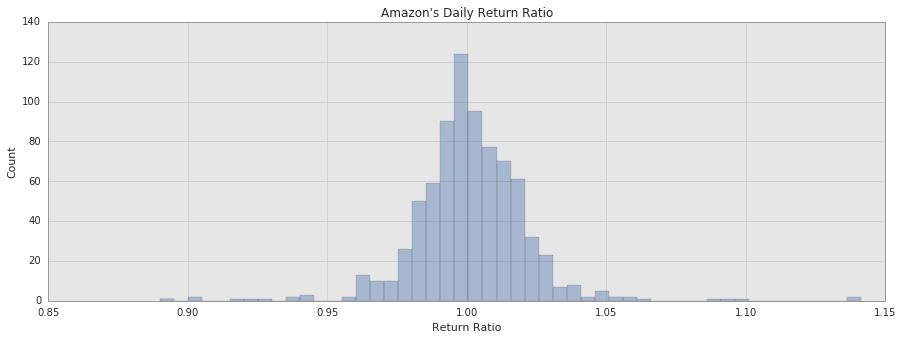

In [5]:
plt.figure(figsize=(15,5));
plt.title("Amazon's Daily Return Ratio");
plt.xlabel('Return Ratio');
plt.ylabel('Count');
sns.distplot(get_daily_return_ratio(tech['AMZN'].values), kde=False);

In [6]:
fit = mle_log_norm(get_daily_return_ratio(tech['AMZN'].values))
fit

array([ 0.00102971,  0.00042114])

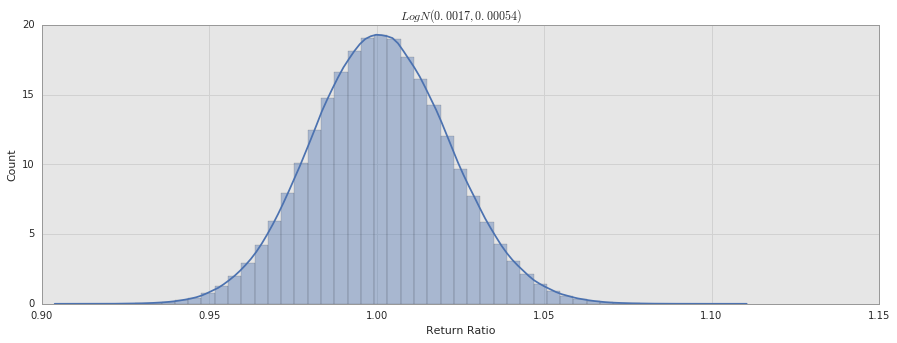

In [7]:
plt.figure(figsize=(15,5));
plt.title(r'$LogN(0.0017, 0.00054)$');
plt.xlabel('Return Ratio');
plt.ylabel('Count');
sns.distplot(np.random.lognormal(fit[0], np.sqrt(fit[1]), size=1000000));

#### Simulating Forcast

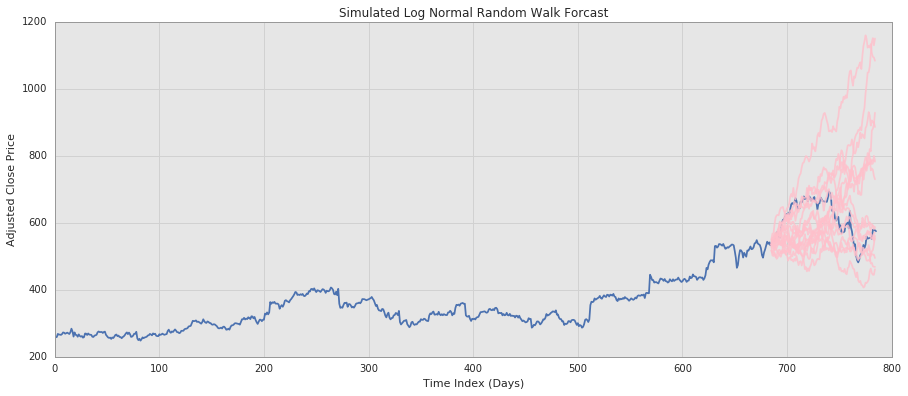

In [8]:
plot_simulated_forcast(tech['AMZN'], window=20, ahead=100, train_on=685, n=15)

#### Deriving a K step ahead forcast:

* __Expected Value__

$$ \mathrm{E}[LogN(\mu, \sigma^2)] = e^{\mu+\sigma^2/2} $$

$$ \frac{Y_t}{Y_{t-1}} \sim LogN(\mu, \sigma^2) \Rightarrow  \hat{Y_{t+1}} = Y_{t} \cdot \mathrm{E}[LogN(\mu, \sigma^2)] $$ 

$$ \hat{Y_{t+k}} = Y_{t+(k-1)} \cdot \mathrm{E}[LogN(\mu, \sigma^2)] \Rightarrow \hat{Y_{t+k}} = Y_t \cdot \mathrm{E}[LogN(\mu, \sigma^2)]^k $$

* __Varience__

$$ \mathrm{E}[LogN(\mu, \sigma^2)] = (e^{\sigma^2}\!\!-1) e^{2\mu+\sigma^2} $$

$$ Z \sim  LogN(\mu, \sigma^2) $$

$$ \mathrm{V}[Y_{t+k}|Y_t] = \mathrm{E}[Y^2_{t+k}|Y_t] - \mathrm{E}[Y_{t+k}|Y_t]^2 $$

$$ \mathrm{V}[Y_{t+k}|Y_t] = Y^2_t \cdot \mathrm{E}[Z^2_{t+1}]^k - Y^2_t \cdot \mathrm{E}[Z_{t+1}]^{2k} $$

$$ \mathrm{V}[Y_{t+k}|Y_t] = Y^2_t \cdot [\mathrm{E}[Z^2_{t+1}]^k - \cdot \mathrm{E}[Z_{t+1}]^{2k}] $$ 

$$ \mathrm{V}[Y_{t+k}|Y_t] = Y^2_t \cdot [(\mathrm{V}[Z_{t+1}] + \mathrm{E}[Z_{t+1}]^{2})^k - \mathrm{E}[Z_{t+1}]^{2k}] $$

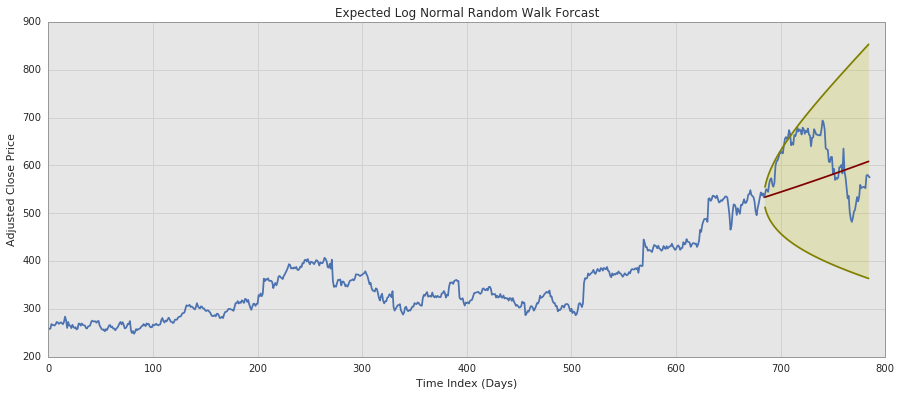

In [9]:
plot_expected_forcast(tech['AMZN'], window=20, ahead=100, train_on=685, error=2)

## Pairs Trade Algorithm

In [10]:
pairs = pd.read_csv('data/pairs_bundle.csv', index_col=0)
pairs.index = pd.to_datetime(pairs.index)

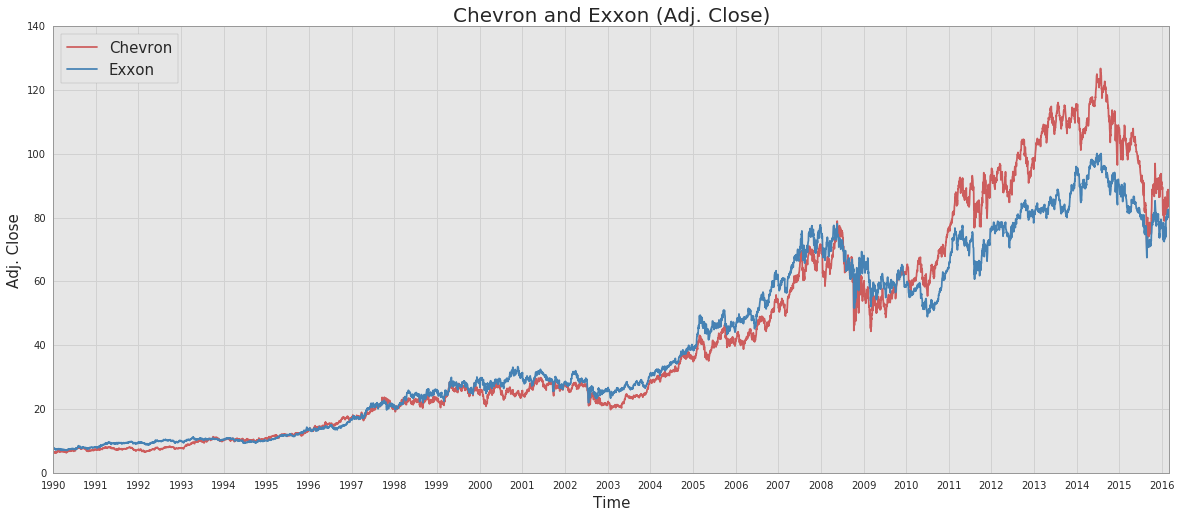

In [11]:
plot_pair(pairs['CVX'], pairs['XOM'], ['Chevron','Exxon'])

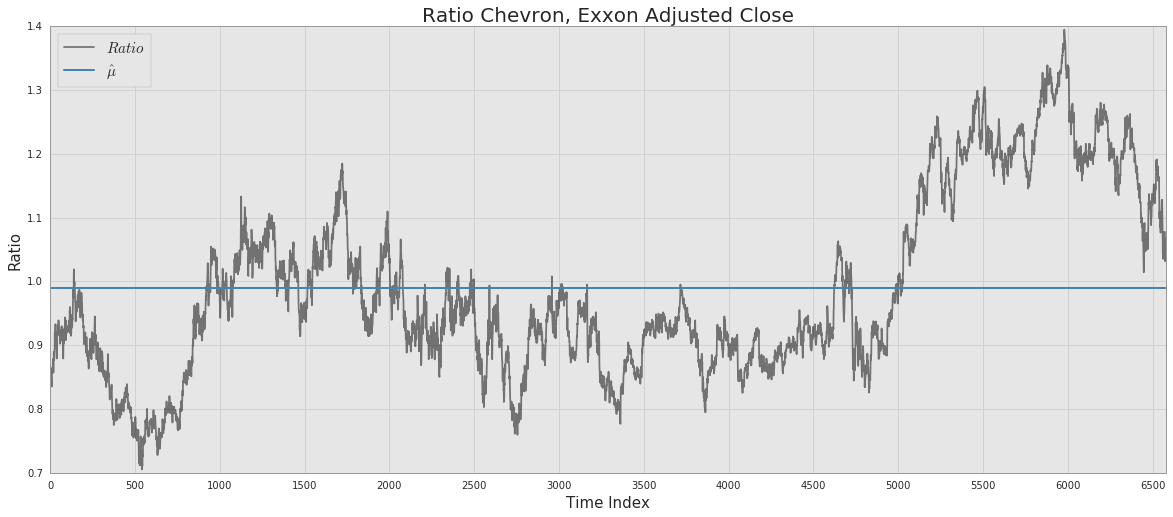

In [12]:
plot_ratio(pairs['CVX/XOM'], 'Chevron, Exxon', deviations=[], positions=[])

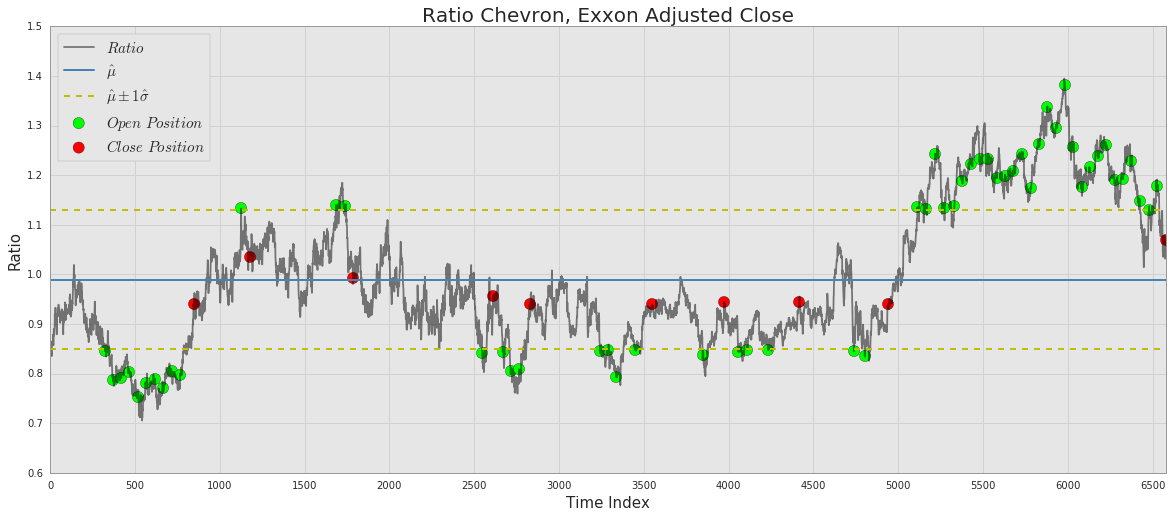

In [13]:
positions_gas = identify_positions(pairs['CVX/XOM'], 1)
plot_ratio(pairs['CVX/XOM'], 'Chevron, Exxon', deviations=[1], positions=positions_gas)

In [14]:
back_trade(10000, pairs['CVX'].values, pairs['XOM'].values, pairs['CVX/XOM'].values, positions_gas, 100)

{'init_investment': 10000,
 'net_gain': 40231.343296289997,
 'net_gain/year': 1540.7748496451488}